# Add src folder to Python path

In [1]:
import sys
import os
ROOT_DIR = os.path.realpath(os.path.join(os.path.abspath(''), '..'))
FOLDER_PATH = os.path.join(ROOT_DIR, "src/")
sys.path.append(FOLDER_PATH)

In [2]:
from app import Application
import pandas as pd
import numpy as np
import joblib
from pprint import pprint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import  ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from skfeature.function.similarity_based import fisher_score

DATA_PATH = "/Users/rasmus/Ohjelmointi/visual_studio/AI_finance/tools/testing_file.csv"

# Used dataset

In [3]:
app = Application()
df = app.data_frame
df.load_data(DATA_PATH)
print(df.get_info_str())

Local path: /Users/rasmus/Ohjelmointi/visual_studio/AI_finance/tools/testing_file.csv
Data loaded from AIDF-file
Used separator: (,) endoding: utf-8

Shape of the DataFrame: (146, 4)
         Date              Receiver  Amount   Category
0  2022-07-31          VR-YHTYMÄ OY  -49.90  COMMUTING
1  2022-07-28  DRESSMANN 707 KAMPPI  -19.95   CLOTHING
2  2022-07-28                   H&M  -19.99   CLOTHING
3  2022-07-27          VR-YHTYMÄ OY  -27.00  COMMUTING
4  2022-07-27     STOCKMANN TAPIOLA  -53.40   CLOTHING
5  2022-07-25            BESTSELLER  -79.99   CLOTHING
6  2022-07-25      NISSEN ISO OMENA   -7.90     HEALTH
7  2022-07-25      PRISMA ISO OMENA  -34.66       FOOD
8  2022-07-25          YA Iso Omena  -11.44     HEALTH
9  2022-07-25   ALEPA OTANIEMI UUSI  -14.56       FOOD

Rows with NaNs:
0

Rows with Empty strings:
2




# Dataset after removing nulls and empty strings

In [4]:
df.remove_empties()
print(df.get_info_str())

Local path: /Users/rasmus/Ohjelmointi/visual_studio/AI_finance/tools/testing_file.csv
Data loaded from AIDF-file
Used separator: (,) endoding: utf-8

Shape of the DataFrame: (144, 4)
         Date              Receiver  Amount   Category
0  2022-07-31          VR-YHTYMÄ OY  -49.90  COMMUTING
1  2022-07-28  DRESSMANN 707 KAMPPI  -19.95   CLOTHING
2  2022-07-28                   H&M  -19.99   CLOTHING
3  2022-07-27          VR-YHTYMÄ OY  -27.00  COMMUTING
4  2022-07-27     STOCKMANN TAPIOLA  -53.40   CLOTHING
5  2022-07-25            BESTSELLER  -79.99   CLOTHING
6  2022-07-25      NISSEN ISO OMENA   -7.90     HEALTH
7  2022-07-25      PRISMA ISO OMENA  -34.66       FOOD
8  2022-07-25          YA Iso Omena  -11.44     HEALTH
9  2022-07-25   ALEPA OTANIEMI UUSI  -14.56       FOOD

Rows with NaNs:
0

Rows with Empty strings:
0




# Factorising running number variables

In [5]:

dataset = df.get_df()
dataset['Day of Month'] = dataset.iloc[:,0].astype('datetime64[ns]').dt.day
dataset['Day of Week']  = dataset.iloc[:,0].astype('datetime64[ns]').dt.dayofweek
dataset.loc[dataset['Day of Week'] >= 5, 'Weekend bool'] = 1
dataset.loc[dataset['Day of Week'] <  5, 'Weekend bool'] = 0
dataset.loc[dataset['Day of Month'] < 35, 'Quarter of Month'] = 3
dataset.loc[dataset['Day of Month'] < 24, 'Quarter of Month'] = 2
dataset.loc[dataset['Day of Month'] < 16, 'Quarter of Month'] = 1
dataset.loc[dataset['Day of Month'] <  8, 'Quarter of Month'] = 0
dataset.loc[dataset.iloc[:,2] <  0, 'Amount sign'] = 1
dataset.loc[dataset.iloc[:,2] >= 0, 'Amount sign'] = 0

X = dataset[['Day of Month', 'Day of Week', 'Amount']]
dataset['Target']  = pd.factorize(dataset.iloc[:,3])[0]
y = dataset['Target']
X_cat = dataset[['Receiver', 'Quarter of Month', 'Weekend bool', 'Amount sign']]

# Plot frequency of classes

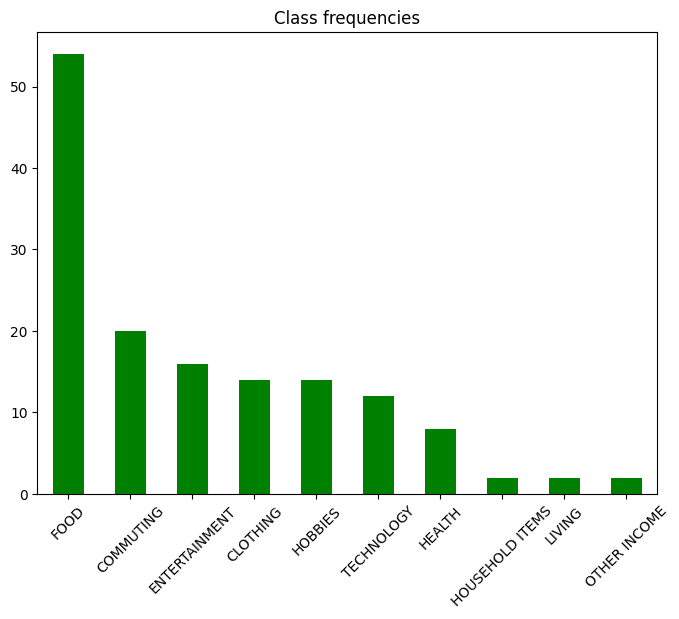

In [6]:


'''
Use to plot individual interactive matplots
'''
#%matplotlib qt 



fig = plt.figure(figsize=(8,6))
dataset['Category'].value_counts().plot.bar(ylim=0, color="green", rot=45)
plt.title('Class frequencies')
plt.show()

# Cross correlation

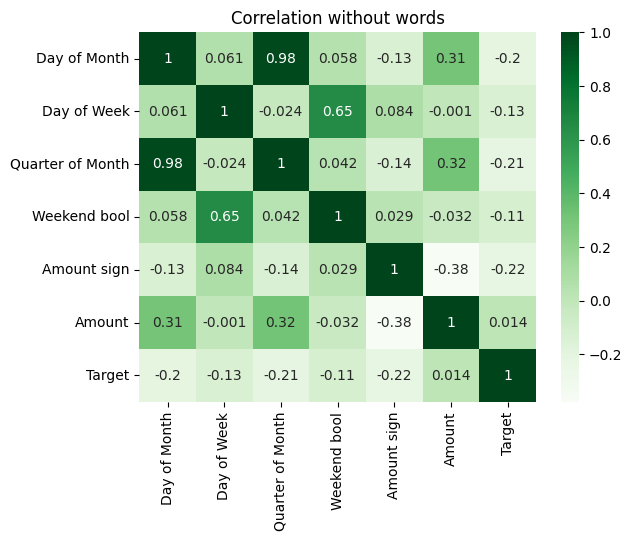

In [7]:
corr = dataset[['Day of Month', 
                'Day of Week', 
                'Quarter of Month', 
                'Weekend bool', 
                'Amount sign', 
                'Amount', 
                'Target']].corr()
sns.heatmap(corr, cmap="Greens", annot=True)
plt.title('Correlation without words')
plt.show()

# Vectorizing text for categorical X

In [8]:
transformer = ColumnTransformer(transformers=[('vec', CountVectorizer(), 0)], 
                                remainder = 'passthrough')
X_cat = transformer.fit_transform(X_cat)
vocabRaw = transformer.get_feature_names_out()
vocab    = [s.replace("vec__", "") for s in vocabRaw]
vocab    = [s.replace("remainder__",  "") for s in vocab]
X_cat = pd.DataFrame(X_cat.toarray(), columns = vocab)

print('Shape of the wordbank + categoricals: ' + str(X_cat.shape) + " (Rows, Columns)")
print(X_cat.head(5))

Shape of the wordbank + categoricals: (144, 102) (Rows, Columns)
   0448  57389  704  707  740  aalto  aaltoyo   ab  adobe  alepa  ...   vr  \
0   0.0    0.0  0.0  0.0  0.0    0.0      0.0  0.0    0.0    0.0  ...  1.0   
1   0.0    0.0  0.0  1.0  0.0    0.0      0.0  0.0    0.0    0.0  ...  0.0   
2   0.0    0.0  0.0  0.0  0.0    0.0      0.0  0.0    0.0    0.0  ...  0.0   
3   0.0    0.0  0.0  0.0  0.0    0.0      0.0  0.0    0.0    0.0  ...  1.0   
4   0.0    0.0  0.0  0.0  0.0    0.0      0.0  0.0    0.0    0.0  ...  0.0   

   waino  xxl   ya  yhtymä  yliopiston  ylioppilaskunta  Quarter of Month  \
0    0.0  0.0  0.0     1.0         0.0              0.0               3.0   
1    0.0  0.0  0.0     0.0         0.0              0.0               3.0   
2    0.0  0.0  0.0     0.0         0.0              0.0               3.0   
3    0.0  0.0  0.0     1.0         0.0              0.0               3.0   
4    0.0  0.0  0.0     0.0         0.0              0.0               3.0   

   

# Information gain

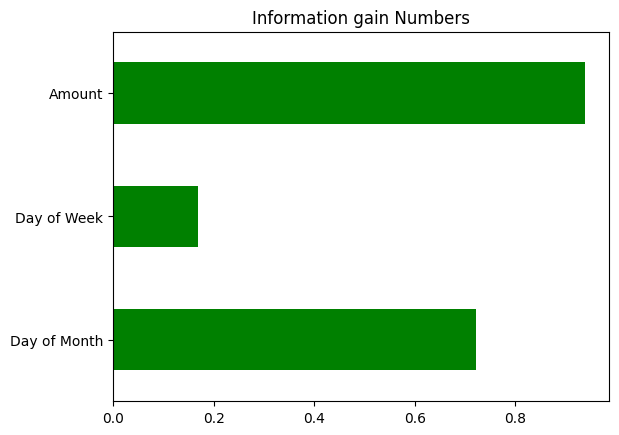

In [9]:
importance = mutual_info_classif(X, y)
feat_importance = pd.Series(importance, X.columns)
feat_importance.plot(kind='barh', color='green')
plt.title('Information gain Numbers')
plt.show()

# Information gain categoricals

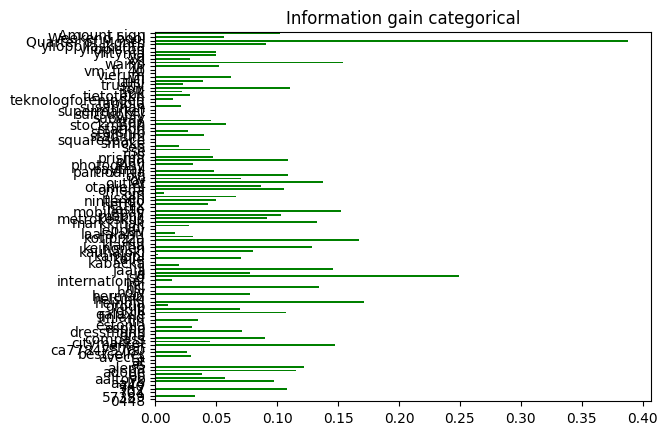

In [10]:
importance = mutual_info_classif(X_cat, y)
feat_importance = pd.Series(importance, X_cat.columns)
feat_importance.plot(kind='barh', color='green')
plt.title('Information gain categorical') 
plt.show()

# Fisher

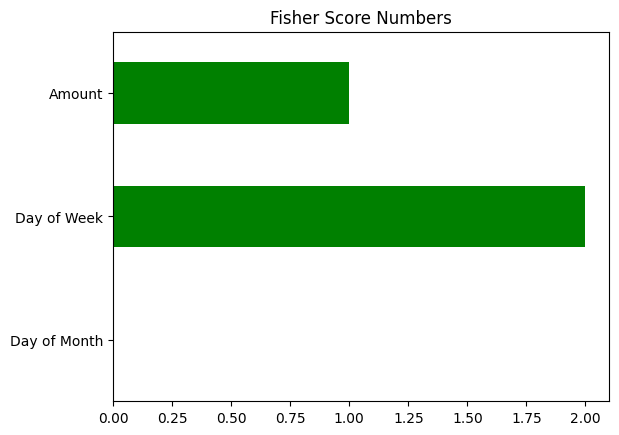

In [11]:
ranks = fisher_score.fisher_score(X.values, y.values)
feat_importance = pd.Series(ranks, X.columns)
feat_importance.plot(kind='barh', color='green')
plt.title('Fisher Score Numbers')
plt.show()

# Fisher categorical

/Users/rasmus/opt/miniconda3/envs/ai_finance_x86/lib/python3.9/site-packages/skfeature/function/similarity_based/fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


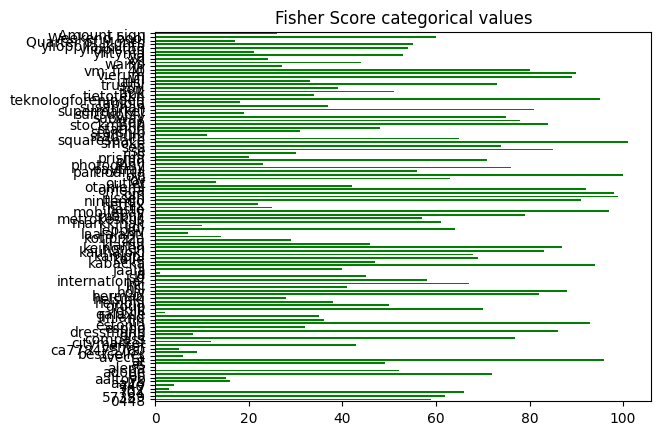

In [12]:
ranks = fisher_score.fisher_score(X_cat.values, y.values)
feat_importance = pd.Series(ranks, X_cat.columns)
feat_importance.plot(kind='barh', color='green')
plt.title('Fisher Score categorical values')
plt.show()

# chi2 categorical

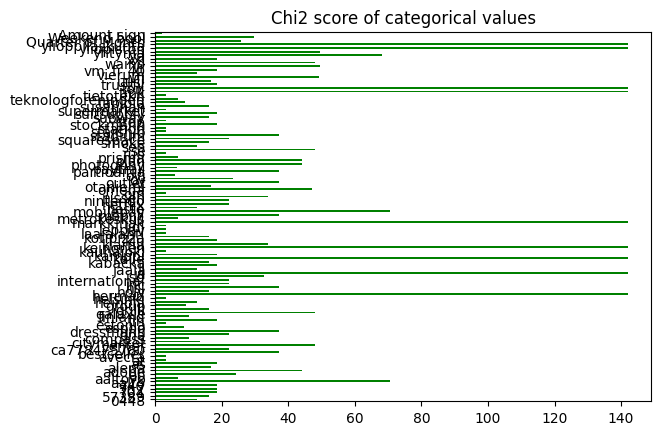

In [13]:
importance = chi2(X_cat, y)[0]
feat_importance = pd.Series(importance, X_cat.columns)
feat_importance.plot(kind='barh', color='green')
plt.title('Chi2 score of categorical values')
plt.show()

# chi2 categorical top50

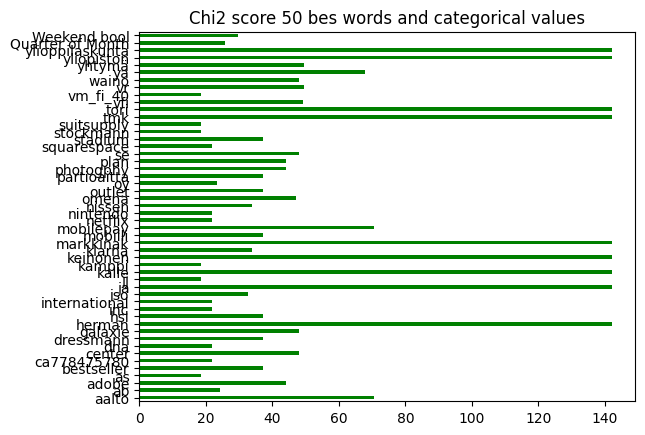

In [14]:
selector = SelectKBest(chi2, k=50)
X_cat_best = selector.fit_transform(X_cat, y)
col_i = selector.get_support(indices=True)
importance = chi2(X_cat_best, y)[0]
feat_importance = pd.Series(importance, X_cat.columns[col_i])
feat_importance.plot(kind='barh', color='green')
plt.title('Chi2 score 50 bes words and categorical values')
plt.show()